In [1]:
import pandas as pd
import numpy as np
from io import StringIO
from classes import BalancedUndersamplingShuffle, balanced_sampling
from helpers import plot_learning_curve, plot_validation_curve, fit_and_score_pipeline, exp_range, \
    validation_curve_with_undersampling, plot_validation_curve_with_undersampling
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.metrics import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.metrics import fbeta_score, make_scorer

In [2]:
from scipy.io import arff

with open('1year.arff','r') as f:
    data1, meta1 = arff.loadarff(f)
    data1 = np.asarray(data1.tolist(), dtype=np.float32)
    print(data1.shape)

with open('2year.arff','r') as f:
    data2, meta2 = arff.loadarff(f)
    data2 = np.asarray(data2.tolist(), dtype=np.float32)
    print(data2.shape)

with open('3year.arff','r') as f:
    data3, meta3 = arff.loadarff(f)
    data3 = np.asarray(data3.tolist(), dtype=np.float32)
    print(data3.shape)

with open('4year.arff','r') as f:
    data4, meta4 = arff.loadarff(f)
    data4 = np.asarray(data4.tolist(), dtype=np.float32)
    print(data4.shape)

with open('5year.arff','r') as f:
    data5, meta5 = arff.loadarff(f)
    data5 = np.asarray(data5.tolist(), dtype=np.float32)
    print(data5.shape)


(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)


In [3]:
data = np.concatenate([data1, data2, data3, data4, data5], axis=0)
data[np.isnan(data)] = 0


# data = data[~np.isnan(data).any(axis=1)]
print(data[:,-1])

print(f'data.shape={data.shape}')

X, y = data[:,:-1], data[:, -1]
# X, y, idx = balanced_sampling(X, y, r = 3, random_state=42)

# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y.astype(str))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print(f'X.shape={X.shape}, y.shape={y.shape}')

[0. 0. 0. ... 1. 1. 1.]
data.shape=(43405, 65)
X.shape=(43405, 64), y.shape=(43405,)


<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773
<class 'sklearn.pipeline.Pipeline'>
a=0.0, r=1, gamma=20.040858725761773


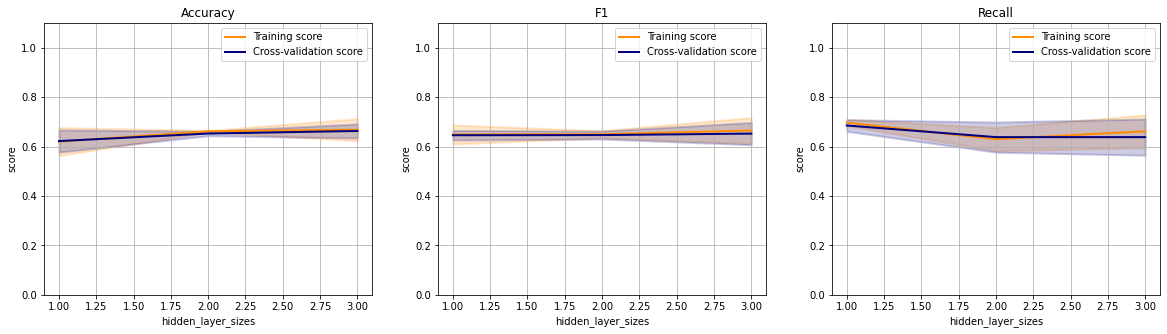

In [5]:
# optimize hidden_layer_sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_range = range(1, 4)
scoring = ['accuracy', 'f1', 'recall']

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
classifier = MLPClassifier(solver='sgd', alpha=1e-2, random_state=0, max_iter=1000)

results_store, plt = plot_validation_curve_with_undersampling(classifier, X_train, y_train, 
                      param_name='hidden_layer_sizes', param_range=param_range, fit_params=None, error_score='raise',
                      cv=cv, scoring=scoring, n_jobs=8, iterations=1, undersampling_ratio=1, is_pipe=True, x_axis_is_log=False)


# for i in param_range:
#     classifier = MLPClassifier(solver='sgd', hidden_layer_sizes=(i,), alpha=1e-2, random_state=0, max_iter=1000)
#     cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#     train_score_f1, test_score_f1, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='f1')
#     train_score_r, test_score_r, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='recall')
#     train_score_p, test_score_p, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='precision')
#     train_score_a, test_score_a, pipe = fit_and_score_pipeline(classifier, X_train, y_train, cv=cv, scoring='accuracy')
#     train_results.append((i, train_score_f1, train_score_r, train_score_p, train_score_a))
#     test_results.append((i, test_score_f1, test_score_r, test_score_p, test_score_a))
